# Scratchpad - Dallas Morning News Case Study

The Dallas Morning News [uncovers a cheating scandal on the TAKS test](http://clipfile.org/?p=754). 

Analyze the data below first, and then see if your findings match the ones in the clip above. Try not to consult the clip above unless you're stuck. The clip also doesn't contain all of the answers so there is still plenty to investigate.


You've recieved a tip that a fourth grade classroom at Harrell Budd Elementary in southern Dallas has unusually high test scores in reading on the TAKS test (the state's standardized test to measure student progress). To check out this claim you've downloaded data from the Texas Education Agency. 

Let's see how the Dallas Morning News used regressions to find evidence of this claim and try to find out if it is an isolated case.



### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **cfy04e4.dat:** 2004 fourth-grade TAKS scores - standardized test scores for 2004's fourth-graders
* **cfy04e5.dat:** 2004 fifth-grade TAKS scores - standardized test scores for 2004's fifth-graders
* **cfy04e3.dat:** 2004 third-grade TAKS scores - standardized test scores for 2004's third-graders

More data you might want
* **cfy03e3.dat:** 2003 third-grade TAKS scores - standardized test scores for 2003's third-graders

Data Documentation: 
https://tea.texas.gov/student-assessment/testing/taks-resources/taks-variables-formats-and-descriptions


In [16]:
# # Make data directory if it doesn't exist
# !mkdir -p data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e4.dat -P data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy03e3.dat -P data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e5.dat -P data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e3.dat -P data

## Finding suspicious behavior by tracking down outliers

In [17]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from plotnine import *

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Reading 2004 test scores data

We'll start by opening up our dataset - standardized test performance at each school, for third, fourth and fifth graders in 2004 in both math and reading.

In [25]:
df_third_grade_2004 = pd.read_csv("data/cfy04e3.dat").set_index('CAMPUS').assign(grade='third')
df_fourth_grade_2004 = pd.read_csv("data/cfy04e4.dat").set_index('CAMPUS').assign(grade='fourth')
df_fifth_grade_2004 = pd.read_csv("data/cfy04e5.dat").set_index('CAMPUS').assign(grade='fifth')

df_2004 = pd.concat([df_third_grade_2004, df_fourth_grade_2004, df_fifth_grade_2004])
df_2004.query('grade=="fourth"')

,DISTRICT,MONTH,YEAR,GRADE,REGION,DNAME,CNAME,STATE,a_docs,a_tst_n,a_abs_n,a_lep_n,a_oth_n,a_all_d,a_sexm_d,a_sexf_d,a_sexv_d,a_ethi_d,a_etha_d,a_ethb_d,a_ethh_d,a_ethw_d,a_ethv_d,a_econ_d,a_eco1_d,a_eco2_d,a_eco9_d,a_ecov_d,a_ecoy_d,a_vocn_d,a_voce_d,a_vocs_d,a_vocp_d,a_vocv_d,a_vocy_d,a_ti1n_d,a_ti1y_d,a_ti1v_d,a_ti18_d,a_ti16_d,a_ti17_d,a_ti19_d,a_mign_d,a_migy_d,a_migv_d,a_lepn_d,a_lepy_d,a_lepv_d,a_biln_d,a_bily_d,a_bilv_d,a_esln_d,a_esly_d,a_eslv_d,a_spen_d,a_spey_d,a_spev_d,a_gifn_d,a_gify_d,a_gifv_d,a_atrn_d,a_atry_d,a_atrv_d,a_all_NM,a_sexm_NM,a_sexf_NM,a_sexv_NM,a_ethi_NM,a_etha_NM,a_ethb_NM,a_ethh_NM,a_ethw_NM,a_ethv_NM,a_econ_NM,a_eco1_NM,a_eco2_NM,a_eco9_NM,a_ecov_NM,a_ecoy_NM,a_vocn_NM,a_voce_NM,a_vocs_NM,a_vocp_NM,a_vocv_NM,a_vocy_NM,a_ti1n_NM,a_ti1y_NM,a_ti1v_NM,a_ti18_NM,a_ti16_NM,a_ti17_NM,a_ti19_NM,a_mign_NM,a_migy_NM,a_migv_NM,a_lepn_NM,a_lepy_NM,a_lepv_NM,a_biln_NM,a_bily_NM,...,s_ethw_rpr,s_ethv_rpr,s_ti1y_rpr,s_ti1n_rpr,s_ti1v_rpr,s_migy_rpr,s_mign_rpr,s_migv_rpr,s_lepy_rpr,s_lepn_rpr,s_lepv_rpr,s_bily_rpr,s_biln_rpr,s_bilv_rpr,s_esly_rpr,s_esln_rpr,s_eslv_rpr,s_spey_rpr,s_spen_rpr,s_spev_rpr,s_gify_rpr,s_gifn_rpr,s_gifv_rpr,s_atry_rpr,s_atrn_rpr,s_atrv_rpr,s_vocy_rpr,s_vocn_rpr,s_vocv_rpr,s_ti16_rpr,s_ti17_rpr,s_ti18_rpr,s_ti19_rpr,s_eco1_rpr,s_eco2_rpr,s_eco9_rpr,s_voce_rpr,s_vocs_rpr,s_vocp_rpr,s_ecoy_rpr,s_econ_rpr,s_ecov_rpr,s_all_rs,s_sexm_rs,s_sexf_rs,s_sexv_rs,s_ethi_rs,s_etha_rs,s_ethb_rs,s_ethh_rs,s_ethw_rs,s_ethv_rs,s_ti1y_rs,s_ti1n_rs,s_ti1v_rs,s_migy_rs,s_mign_rs,s_migv_rs,s_lepy_rs,s_lepn_rs,s_lepv_rs,s_bily_rs,s_biln_rs,s_bilv_rs,s_esly_rs,s_esln_rs,s_eslv_rs,s_spey_rs,s_spen_rs,s_spev_rs,s_gify_rs,s_gifn_rs,s_gifv_rs,s_atry_rs,s_atrn_rs,s_atrv_rs,s_vocy_rs,s_vocn_rs,s_vocv_rs,s_ti16_rs,s_ti17_rs,s_ti18_rs,s_ti19_rs,s_eco1_rs,s_eco2_rs,s_eco9_rs,s_voce_rs,s_vocs_rs,s_vocp_rs,s_ecoy_rs,s_econ_rs,s_ecov_rs,s_obj1_NI,s_obj1_RI,s_obj2_NI,s_obj2_RI,s_obj3_NI,s_obj3_RI,s_obj4_NI,s_obj4_RI
CAMPUS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1902103,1902,4,4,4,7,CAYUGA ISD,CAYUGA EL,1,42.0,38.0,0,0,4,38,18,20,0,0,0,4,1,33,0,28,6,4,0,0,10,0,0,0,0,38,0,34,4,0,0,0,4,0,38,0,0,38,0,0,38,0,0,38,0,0,38,0,0,28,10,0,36,2,0,36.0,18.0,18.0,NaN,NaN,NaN,NaN,NaN,31.0,NaN,26.0,6.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,36.0,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,36.0,NaN,NaN,36.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903101,1903,4,4,4,7,ELKHART ISD,ELKHART EL,1,67.0,67.0,0,0,0,67,31,36,0,0,0,8,2,57,0,27,29,11,0,0,40,0,0,0,0,67,0,0,67,0,0,67,0,0,67,0,0,67,0,0,67,0,0,67,0,0,65,2,0,61,6,0,56,11,0,54.0,28.0,26.0,NaN,NaN,NaN,4.0,NaN,48.0,NaN,23.0,20.0,11.0,NaN,NaN,31.0,NaN,NaN,NaN,NaN,54.0,NaN,NaN,54.0,NaN,NaN,54.0,NaN,NaN,54.0,NaN,NaN,54.0,NaN,NaN,54.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1904102,1904,4,4,4,7,FRANKSTON ISD,FRANKSTON EL,1,71.0,65.0,0,1,5,65,37,28,0,0,0,11,1,53,0,35,23,7,0,0,30,0,0,0,0,65,0,0,65,0,0,65,0,0,65,0,0,64,1,0,65,0,0,64,1,0,62,1,2,60,5,0,59,6,0,42.0,26.0,16.0,NaN,NaN,NaN,1.0,NaN,40.0,NaN,28.0,10.0,4.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,42.0,NaN,NaN,42.0,NaN,NaN,42.0,NaN,NaN,42.0,NaN,NaN,41.0,NaN,NaN,42.0,NaN,...,NaN

In [22]:
# Here is the dataframe above in long format if you'd prefer it that way!
df_long = df.melt(id_vars=['CAMPUS', 'CNAME']).dropna()
df_long

,CAMPUS,CNAME,variable,value
0,1902103,CAYUGA EL,r_all_rs_third,2410.0
1,1903101,ELKHART EL,r_all_rs_third,2256.0
2,1904102,FRANKSTON EL,r_all_rs_third,2284.0
3,1906102,NECHES EL,r_all_rs_third,2294.0
4,1907110,STORY EL,r_all_rs_third,2256.0
...,...,...,...,...
25416,241902041,EAST BERNARD J,m_all_rs_fifth,2297.0
25418,243902041,ELECTRA J H,m_all_rs_fifth,2129.0
25419,249905102,DECATUR INT,m_all_rs_fifth,2255.0
25420,250907041,MEMORIAL MIDDLE,m_all_rs_fifth,2241.0


# Plotting

## Descriptive Stats

In [4]:
df.describe().round(1)

,CAMPUS,r_all_rs_third,m_all_rs_third,r_all_rs_fourth,m_all_rs_fourth,r_all_rs_fifth,m_all_rs_fifth
count,4237.0,3745.0,3749.0,3706.0,3709.0,3453.0,3452.0
mean,115343592.6,2274.5,2238.9,2227.2,2217.5,2202.5,2220.4
std,71979517.5,63.2,74.8,68.6,78.5,89.0,98.3
min,1902103.0,1858.0,1924.0,1951.0,1898.0,1805.0,1816.0
25%,57909110.0,2234.0,2193.0,2181.0,2168.0,2141.0,2157.0
50%,101912217.0,2276.0,2239.0,2226.0,2216.0,2200.0,2216.0
75%,178902103.0,2318.0,2288.0,2273.0,2268.0,2260.0,2282.0
max,254902101.0,2503.0,2497.0,2509.0,2520.0,2476.0,2696.0


### Example Histogram

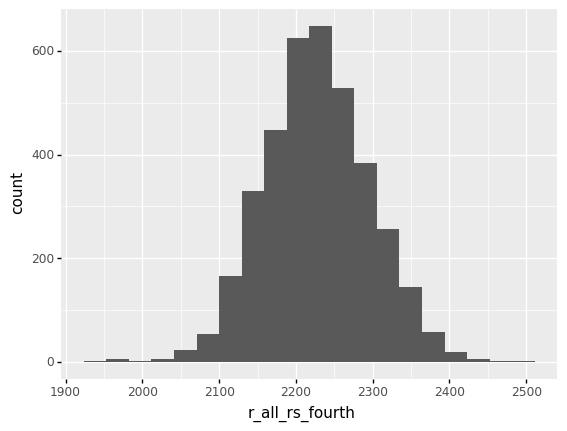

<ggplot: (335426407)>

In [5]:
to_plot = df.query('r_all_rs_fourth.notna()')

(
    ggplot(to_plot, aes(x='r_all_rs_fourth')) + 
        geom_histogram(bins=20)
)

## Example Scatter Plot

/Users/mehtad/.pyenv/versions/3.9.7/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 149 rows containing missing values.


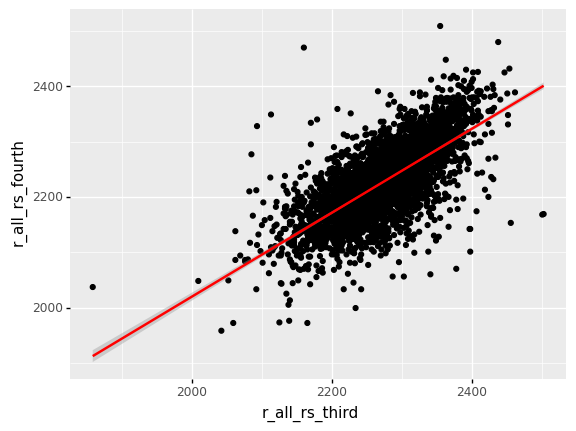

<ggplot: (335495178)>

In [6]:
to_plot = df.query('r_all_rs_fourth.notna()')

(
    ggplot(to_plot, aes(x='r_all_rs_third', y='r_all_rs_fourth')) + 
        geom_point() + 
        geom_smooth(method='lm', color='red')
)

## Example Regression

Using a regression to predict fourth-grade reading scores


In [7]:
import statsmodels.formula.api as smf

df = df.query('r_all_rs_fourth.notna() and r_all_rs_third.notna()')
model = smf.ols("r_all_rs_fourth ~ r_all_rs_third", data=df)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        r_all_rs_fourth   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     3410.
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:59:27   Log-Likelihood:                -18903.
No. Observations:                3557   AIC:                         3.781e+04
Df Residuals:                    3555   BIC:                         3.782e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        504.0130     29.526     17.070      0.000     446.123     561.903
r_all_rs_third     0.7579      0.013     58.398      0.000       0.732       0.783
==============================================================================
Omnibus:                      182.214   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              599.474
Skew:                          -0.164   Prob(JB):                    6.70e-131
Kurtosis:                       4.984   Cond. No.                     8.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
# Comparing actual to predicted values
df['actual'] = df.r_all_rs_fourth
df['predicted'] = results.predict()
df

/var/folders/bp/5dzvdsg55xn25gp9vjh1f4xc0000gn/T/ipykernel_15336/2243843013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/bp/5dzvdsg55xn25gp9vjh1f4xc0000gn/T/ipykernel_15336/2243843013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CAMPUS,r_all_rs_third,m_all_rs_third,r_all_rs_fourth,m_all_rs_fourth,r_all_rs_fifth,m_all_rs_fifth,CNAME,actual,predicted
0,1902103,2410.0,2388.0,2392.0,2227.0,2308.0,2317.0,CAYUGA EL,2392.0,2330.500194
1,1903101,2256.0,2208.0,2263.0,2192.0,2193.0,2153.0,ELKHART EL,2263.0,2213.786905
2,1904102,2284.0,2313.0,2242.0,2152.0,2288.0,2256.0,FRANKSTON EL,2242.0,2235.007503
3,1906102,2294.0,2273.0,2218.0,2096.0,2298.0,2312.0,NECHES EL,2218.0,2242.586288
4,1907110,2256.0,2205.0,2200.0,2168.0,2218.0,2269.0,STORY EL,2200.0,2213.786905
...,...,...,...,...,...,...,...,...,...,...
3804,252903101,2270.0,2241.0,2193.0,2234.0,2188.0,2313.0,OLNEY EL,2193.0,2224.397204
3805,253901101,2208.0,2189.0,2109.0,2086.0,1985.0,2088.0,BENAVIDES EL,2109.0,2177.408737
3806,253901106,2198.0,2253.0,2172.0,2181.0,2140.0,2202.0,ZAPATA SOUTH EL,2172.0,2169.829952
3807,253901107,2190.0,2178.0,2155.0,2171.0,2076.0,2168.0,ZAPATA CENTRAL,2155.0,2163.766925


In [15]:
# showing the residuals
df['error'] = results.resid
df['error_std_dev'] = df.error/df.error.std()
df

/var/folders/bp/5dzvdsg55xn25gp9vjh1f4xc0000gn/T/ipykernel_15336/4148118840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/bp/5dzvdsg55xn25gp9vjh1f4xc0000gn/T/ipykernel_15336/4148118840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CAMPUS,r_all_rs_third,m_all_rs_third,r_all_rs_fourth,m_all_rs_fourth,r_all_rs_fifth,m_all_rs_fifth,CNAME,actual,predicted,error,error_std_dev
0,1902103,2410.0,2388.0,2392.0,2227.0,2308.0,2317.0,CAYUGA EL,2392.0,2330.500194,61.499806,1.250382
1,1903101,2256.0,2208.0,2263.0,2192.0,2193.0,2153.0,ELKHART EL,2263.0,2213.786905,49.213095,1.000575
2,1904102,2284.0,2313.0,2242.0,2152.0,2288.0,2256.0,FRANKSTON EL,2242.0,2235.007503,6.992497,0.142168
3,1906102,2294.0,2273.0,2218.0,2096.0,2298.0,2312.0,NECHES EL,2218.0,2242.586288,-24.586288,-0.499876
4,1907110,2256.0,2205.0,2200.0,2168.0,2218.0,2269.0,STORY EL,2200.0,2213.786905,-13.786905,-0.280308
...,...,...,...,...,...,...,...,...,...,...,...,...
3804,252903101,2270.0,2241.0,2193.0,2234.0,2188.0,2313.0,OLNEY EL,2193.0,2224.397204,-31.397204,-0.638352
3805,253901101,2208.0,2189.0,2109.0,2086.0,1985.0,2088.0,BENAVIDES EL,2109.0,2177.408737,-68.408737,-1.390851
3806,253901106,2198.0,2253.0,2172.0,2181.0,2140.0,2202.0,ZAPATA SOUTH EL,2172.0,2169.829952,2.170048,0.044120
3807,253901107,2190.0,2178.0,2155.0,2171.0,2076.0,2168.0,ZAPATA CENTRAL,2155.0,2163.766925,-8.766925,-0.178245


# Finding suspicious datapoints with linear regression

Is Harrell Budd Elementary's fourth grade reading classrooms the only place where we see cheating in 2004? 

How else can you design regressions to help you uncover other instances of cheating? 

In the cells below, try to define your own questions and see if you can uncover other suspicious scores using regressions. You may also want to use plots as necessary. You can start with reading (`r_all_rs`) and math (`m_all_rs`) scores in the data we have loaded, but if you'd like, you're also welcome to bring in other variables from the [data documentation](
https://tea.texas.gov/sites/default/files/TAKS-Variables-prior2005.pdf).

- If you've got an interesting finding, put up a green sticky note! 🟩

- If you're stuck, put up a red sticky note! 🟥